In [13]:
import numpy as np
import math
import json
import random

def waveforms(N_A, N_g, N_f, t0_tf, T, B, trials, seedn=1, inputfile="input", phi0=0, A0=1, 
              Af=50, g0=0, gf=2, F0=90, Ff=110, N=1000):
    """
    METHOD
    ======
    Takes parameter inputs of a wave and the strength and duration of
    noise, and combines the two to form a data for each trial.
    
    PARAMETERS
    ==========
    N_A : (Int) Number of potential amplitudes
    N_g : (Int) Number of potential gammas
    N_f : (Int) Number of potential frequencies
    t0_tf : (Float) Time duration of signal
    T : (Float) Time stamp of the end time of the data. Default = None
    B : (Float) Noise amplitude of waveform
    trials : (Int) Number of different waveforms to make
    inputfile : (String) Name of json file produced containing each trial's parameters and data
    phi0 : (Float) Initial phase of the signal. Default = 0.0
    A0, Af : (Float) Amplitude lower/upper bounds
    g0, gf : (Float) Gamma lower/upper bounds
    F0, Ff : (Float) Frequency lower/upper bounds
    N : (Int) Divisions in total time series 
    
    OUTPUT
    ======
    A dictionary is created with a component for each trial, consisting
    of a list of the parameters used to create the data, and a list of
    the data. This is stored in a newly written json file.
    
    """
    
    # initalizes the arrays which span parameter space, and their lengths
    A_RANGE=np.linspace(A0,Af,N_A)
    G_RANGE=np.linspace(g0,gf,N_g)
    F_RANGE=np.linspace(F0,Ff,N_f)

    # number of parameters available
    A_LEN, G_LEN, F_LEN = N_A, N_g, N_f
    
    waveform_data={}
    for j in range(trials):
        waveform_data.update({j:[[],[]]})
        
        # calculates random indice for each parameter (A, f, g)
        A_RAN=random.randint(0,A_LEN-1)
        G_RAN=random.randint(0,G_LEN-1)
        F_RAN=random.randint(0,F_LEN-1)
        
        # calculates random parameters A, f, g
        A, gamma, f = A_RANGE[A_RAN], G_RANGE[G_RAN], F_RANGE[F_RAN]
        
        dt=T/N # time resolution

        t0=(T-t0_tf)*np.random.random(1)[0]  # randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

        ##NOTE: using 't0' instead of some multiple of dt may cause issues later
        
        SIG_LEN = (math.floor(t0_tf/dt)+1 if (t0_tf != T) else N) # calculate # of indexes signal takes
        INJECTED = np.zeros(N)                 # initalize injected signal, with N size array of zeroes
        for i in range(SIG_LEN):
            INJECTED[START_INDEX + i]=t0+i*dt       # fill in injected signal with its time stamps

        w = 2 * np.pi * f
        
        # replace timestamps with their displacement values
        SR = INJECTED[START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*(SR-t0) + phi0)*np.exp(-gamma*(SR-t0))
        
        # Purposed for Quadrature Sum
        D_i = [] # list of each differently seeded waveform
        for n in range(seedn):
            np.random.seed(seed = n)
            NOISE = np.random.normal(scale=(B/(math.sqrt(3)*2)), size=N)  # Noise!
            D_i.append(list(NOISE + INJECTED))  # complete data!
        
        # gets parameters and data for each trial, stuffs it into dictionary
        parameters = [A, f, gamma, t0]
        waveform_data[j][0], waveform_data[j][1] = parameters, D_i
        
    # each trial has list of parameters used and list of data values
    with open("{}-waveform_data.json".format(inputfile) , "w") as f:
        json.dump(waveform_data, f, indent=2, sort_keys=True)

In [14]:
#  N_A, N_g, N_f, t0_tf, T, B, trials
waveforms(4, 4, 4, 4, 10, 10, 10, N=250, seedn=3)

In [25]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time

class Statudio:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, trials, seedn = 1, inputfile="input", 
                 outputfile="output", A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):
        
        print('very start...')
        """
        METHOD: 
        Generates a set of wave templates spanning the parameter space of amplitude, frequency and gamma;
        Generates a set of datasets with injected signals via random A, f, gamma, and start time
        Creates cross-correlation/chi-squared stats with the above
        Lastly, saves the above internally as attributes, and externally as a .json file
        
        PARAMETERS:
        -----------
        N_A: divisions in amplitude
        N_g:  divisions in gamma
        N_f: divisions in frequency
        t0_tf: length of template interval [t0, tf] in time
        T: length of total time series, in units of time
        b: noise amplitude
        D: foreground/background interval length
        trials: number of random data sets generated
        A0, Af : amplitude lower/upper bounds
        g0, gf : gamma lower/upper bounds
        F0, ff : frequency lower/upper bounds
        N_t= divisions in total time series 
        
        OUTPUT: Returns global maximum values for given ranges, and produces txt
        value containing all of them
        """
        
        print('initalizing output...')
        """initalizes a dictionary of arrays to hold info and later save as a .json
        key i: returns an array of arrays containing datset i and other relavent values
                component 0: true A, f, g & t0 corresoponding to dataset i
                component 1: dataset i
                component 2: cross corelations between dataset and each template
                component 3: chi squares between dataset and each template
        """

        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)

        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)

        # constructs timestep resolution, and saves N and t0/tf internally 
        self.N, self.dt, self.t0_tf= N_t, T/N_t, t0_tf

        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/(T)))))
        self.t_LEN=len(self.t_RANGE)
        self.T=T

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor=[]
        self.chi=[]

        print('building pairs/templates...')
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AFG=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]

        self.AFG_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]

        # Reads waveform data file 
        with open("{}-waveform_data.json".format(inputfile),"r") as f: 
            waveform_data = json.load(f)

        self.waveform_data = waveform_data

        self.trials=trials
        output={}

        print('starting data/template loop...')
        for i in range(trials):            
            
            output.update({i:[[],[],[],[]]})
            
            # isolates random a-g-f pair / data set 
            temp_AGFT, data = waveform_data[str(i)][0], waveform_data[str(i)][1]
            
            self.noise.append(data) 
            
            output[i][0], output[i][1] = temp_AGFT, data  # stores random a-g-f pair / data set 
            
            Quad_CRS = []
            Quad_CHI = []
            # performs base static calculation across parameter space
            # Quadrature Sum
            for n in range(seedn): # Use seedn as index for data
                
                CRS_COR, CHI_SQR = [[],[]]
                
                for template in self.TEMPLATES_AFG:

                    CC_dh = list(self.CrossCorrelation(data[n], template, self.dt))
                    CRS_COR.append(CC_dh)

                    CS_dh = list(self.ChiSquare(data[n], template, self.dt))
                    CHI_SQR.append(CS_dh)
                
                Quad_CRS.append(CRS_COR) # now a 3d list of seedn statistics, with 2d list statistics per waveform
                Quad_CHI.append(CHI_SQR)
                
            CRS_COR = np.sum(np.array(Quad_CRS) ** 2, axis = 0) ** .5 # Quadrature sum of each seed's statistic
            CHI_SQR = np.sum(np.array(Quad_CHI) ** 2, axis = 0) ** .5
            
            # stores base statistics to attribute
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        # sets output as a attribute
        self.output = output
        
        # saves 'output' as a .json in current working directory.
        '''with open("{}.json".format(outputfile), "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    #calculates test statistic, stroes it internally,
    #and returns a copy of it as a dictionary 
    def rho(self, stat=None):
        
        # String to equation!
        if stat == None:
            stat = "CC_IJ/abs((1+CS_IJ))"
            
        # counts number of tempates in parameter space
        PSPACE_LEN = len(self.AFG_PAIR)
    
        # initalizes rho statistic dictionary
        self.RHO = {}
        # indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i = []
        
            # indexed to loops through parameter space templates and
            # calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ = np.array(self.cross_cor[i][j][:])
                CS_IJ = np.array(self.chi[i][j][:])
                
                # Evaluates string (Exec gave issues... eval is the same concept though)
                p = eval(stat)
                rho_i.append(list(p))
            self.RHO.update({ i : rho_i })
        
        self.stat = stat
        
        return self.RHO

    def modulator(self, rho_ij, D):

        rho_mod_D, RHO_ij = [] , rho_ij[:]
    
        dn , L = math.floor(2*D/self.dt) , len(RHO_ij)

        for i in range(0,L-(L%dn),dn):
            rho_mod_D.append(max(RHO_ij[i:i+dn]))
        
        if (L-(L%dn)) != L :
            rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))
        
        return rho_mod_D

    def window(self, D):
        
        if (2*D >= self.dt):
            
            #gets the length of linearized template space
            TEMP_LEN=len(self.cross_cor[0])
            
            self.RHO_MOD={}
            self.MAX_OS={}
            self.MAX_BG_TEMP={}
            find_thresh = []
            
            for j in range(TEMP_LEN):
                self.MAX_BG_TEMP.update({ j : 0})
            
            for i in range(self.trials):

                # gets the length
                TEMP_LEN = len(self.cross_cor[i])
                
                # seperates fg value from bg value
                T0_2D = math.floor(self.output[i][0][3]/(2*D))
                
                BG_VALS_IJ, FG_VAL_IJ = [], []
                for j in range(TEMP_LEN):
                
                    # calculates bg values + fg values
                    BG_VALS_IJ.append(self.modulator(self.RHO[i][j][:],D))

                    FG_VAL_IJ.append(BG_VALS_IJ[j].pop(T0_2D))
                    
                find_thresh += FG_VAL_IJ # 1d list of all forground values 
                self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] }) # these are the peaks we look for
                self.MAX_OS.update({ i :[tuple(self.output[i][0][0:3]),max(self.RHO_MOD[i][1])] })
                
                for j in range(TEMP_LEN): 
                    new_max=max(self.RHO_MOD[i][0][j])
                    
                    if (self.MAX_BG_TEMP[j]< new_max):
                        self.MAX_BG_TEMP[j]=new_max
                
            self.pot_thresh0 = min(find_thresh) # Used to set thresholds in ROC Curve
            self.pot_threshf = max(find_thresh)
            
            return self.RHO_MOD
        
        else: 
            print("invalid D; it is required that 2*D >= T/N")

    def test_plotter(self, T, N, var1=0, var2=0,bg_test=True):
        
        # Calculates the index of the attribute variable
        # (A, F, or G) which the heat map should marginaliz 
        # over
        if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
            if ((0<= var1) and (0<= var2)):  #checks if range valid
                if (var2 < var1):            #properly orders
                    var1, var2 = var2, var1
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index
                    
                elif (var2==var1):
                    index=var2  # if the values are the same, set as index
                    
                else:
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            else:
                print("improper index inputs: both must be >= 0")
                index=0
        else:
            print("improper index inputs: both must be <= 2")
            index=0

        mapping={}   #initalizes mapping for heat map
    
        holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        
        # builds link between keys and np-array 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    F=self.F_RANGE[j]
                    A=self.A_RANGE[i]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)]=[0]
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})

        #initalizes threshold axis points, counts for each threshold
        #and space of parameter space
        THRS_AXIS=[]
        COUNT_AXIS=[]
        PSPACE_LEN=len(self.AFG_PAIR)
        PSACE_PAIRS=[]

        #sets current threshold value
        for thrshld in np.linspace(0,T,N):

            THRS_AXIS.append(thrshld)
            succ_count_thrhld=0
        
            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count=0
                for j in range(PSPACE_LEN):
                
                    RM_ij=np.array(self.RHO_MOD[i][0][j])
                    FG_ij=self.RHO_MOD[i][1][j]
                    N_BG_ij=len(RM_ij[ RM_ij > FG_ij])
                
                    #tests if the given pair passes the threshold test
                    if (bg_test==True):
                        if ((N_BG_ij==0) and (FG_ij > thrshld)):

                            if heat_count==0:
                                succ_count_thrhld+=1
                                mapping[tuple(self.output[i][0][:3])][0]+=1
                                heat_count+=1
                    else:
                        if (FG_ij > thrshld):

                            if heat_count==0:
                                succ_count_thrhld+=1
                                mapping[tuple(self.output[i][0][:3])][0]+=1
                                heat_count+=1
        
            COUNT_AXIS.append(succ_count_thrhld)
        
        plt.plot(THRS_AXIS,COUNT_AXIS)
        plt.xlabel("$Threshold$")
        plt.ylabel("Counts")
        plt.show()
        
        #redefines things to be normal arrays inside 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
        
        #marginalizes array in direction of index
        index=int(index)
        w=holder.sum(index)
        
        #builds a copy of the original array, but fixes things to be integers 
        cop=np.full(w.shape,0)
        z=[(i,j) for i in range(w.shape[0]) for j in range(w.shape[1])]
        for tup in z:
            cop[tup]=int(w[tup])
    
        label=np.array(["amplitude","frequency", "gamma"])
        x=np.array([0, 1, 2])
        x=x[ x != index]
        
        plt.imshow( cop, cmap=plt.cm.hot)
        plt.xlabel(label[x[1]])
        plt.ylabel(label[x[0]])
    
        #plt.imshow( heat_array, cmap=plt.cm.hot) 
    
    def ROC_Data(self, T0, Tf, N):
        
        PSPACE_LEN=len(self.AFG_PAIR)

        # Stats per threshold
        self.Detection_Prob = []
        self.New_False_Prob = []
        
        #sets current threshold value
        for thrshld in np.linspace(T0,Tf,N):
            
            # Detection/ False Alarm probability counters
            Detect_count = 0
            False_count = 0
        
            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                
                # Detection Probability
                Max_FG_ij = max(self.RHO_MOD[i][1]) # max of onsources per trial
                if Max_FG_ij > thrshld:
                    Detect_count += 1
                
                for j in range(PSPACE_LEN):
                
                    RM_ij=np.array(self.RHO_MOD[i][0][j])
                    FG_ij=self.RHO_MOD[i][1][j]
                    N_BG_ij=len(RM_ij[ RM_ij > FG_ij])
                    
                    # False Alarm probability
                    falses_ij = len(RM_ij[RM_ij > thrshld])
                    False_count += falses_ij
        
            # Detection/False Alarm probability stats
            Detect_stat = Detect_count / self.trials
            False_stat = False_count / (len(self.RHO_MOD[i][0][0]) * PSPACE_LEN * self.trials)

            # Appending stat per threshold
            self.Detection_Prob.append(Detect_stat)
            self.New_False_Prob.append(False_stat)
            
    def ROC_Curve(self, n_s, N, new_stat_only=True, outputfile="ROC_test"):
        
        # Choose soley n-rho's or an addition stat
        if new_stat_only == True:
            stat_list = []
        else:
            stat_list = ["CC_IJ","CS_IJ"]
            
        # different ^n rhos are appended
        for n in range(1,n_s+1):
            rho = "CC_IJ/((1+abs(CS_IJ))**{})".format(n)
            stat_list.append(rho)
        
        stat_length = len(stat_list)
        for s in range(stat_length):
    
            self.rho(stat = stat_list[s])
            self.window(.02)
            self.ROC_Data(self.pot_thresh0, self.pot_threshf, N)
            plt.plot(self.New_False_Prob, self.Detection_Prob, label=stat_list[s])
            
        plt.xlabel("New_False_Probs")
        plt.ylabel("Detection_Probs")
        plt.title("ROC Curve:n's={}:N={}".format(n_s,N))
        plt.legend()
        plt.savefig("{}-ROC.png".format(outputfile))
        plt.show()
        
    def Scatter_plotter(self, thrshld, xvar, yvar): 
    
        label=["amplitude","frequency", "gamma"]
        PSPACE_LEN=len(self.AFG_PAIR)
        SUCC_PAIRS=([],[])
        FAIL_PAIRS=([],[])

        #loops from trial/ parameter space pairs 
        for i in range(self.trials):
        
            succ_count_thrhld=0  #test condition for adding to fail array

            for j in range(PSPACE_LEN):
            
                RM_ij=np.array(self.RHO_MOD[i][0][j])  #get moded rho_ij background values
                FG_ij=self.RHO_MOD[i][1][j]            #get moded rho_ij foreground value
                N_BG_ij=len(RM_ij[ RM_ij > FG_ij])     # get background vals > froeground vals
                
                #tests if the given pair passes the threshold test
                if ((N_BG_ij==0) and (FG_ij > thrshld)):
                
                    parameter_x=self.output[i][0][xvar]  #get parameter 'xvar' of trial i
                    parameter_y=self.output[i][0][yvar]  #get parameter 'yvar' of trial i
                    SUCC_PAIRS[0].append(parameter_x) #add to successes
                    SUCC_PAIRS[1].append(parameter_y)
                    succ_count_thrhld+=1
                    break
        
            #sees if trial i failed the test; adds parameters to fail array
            if succ_count_thrhld==0:
                parameter_x=self.output[i][0][xvar]
                parameter_y=self.output[i][0][yvar]
                FAIL_PAIRS[0].append(parameter_x)
                FAIL_PAIRS[1].append(parameter_y)
    
        colors = ("red", "blue")
        groups = ("pass", "fail")
        marks = ("o", "*")
        data = ( SUCC_PAIRS, FAIL_PAIRS )
    
        # Create plot
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        for data, marks, color, group in zip(data, marks, colors, groups):
            x , y = data
            ax.scatter(x, y, marker=marks, c=color, edgecolors='none', s=30, label=group)

        plt.title('found-missed plot')
        plt.xlabel(label[xvar])
        plt.ylabel(label[yvar])
        plt.legend(loc=2)
        plt.show()

    def index_counter(self,var1,var2):
        # Calculates the index of the attribute variable
        # (A, F, or G) which the heat map should marginaliz 
        # over
        if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
            if ((0<= var1) and (0<= var2)):  #checks if range valid
                if (var2 < var1):            #properly orders
                    var1, var2 = var2, var1
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index
                    
                elif (var2==var1):
                    index=var2  # if the values are the same, set as index
                    
                else:
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            else:
                print("improper index inputs: both must be >= 0")
                index=0
        else:
            print("improper index inputs: both must be <= 2")
            index=0
        
        return index

    def heatmap(self, var1, var2, T, max_OS=-1, max_BG=-1):
        
        index=self.index_counter(var1,var2)
        
        mapping={}   #initalizes mapping for heat map
        count_mapping={} #initalies array to count occurances of certain parameters
        BG_mapping={}

        holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        count_holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        BG_holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        
        # builds link between keys and np-array 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    F=self.F_RANGE[j]
                    A=self.A_RANGE[i]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)]=[0]
                    count_holder[(i,j,k)]=[0]
                    BG_holder[(i,j,k)]=[0]
                    
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
                    count_mapping.update({ (A,F,G) : count_holder[(i,j,k)]})
                    BG_mapping.update({ (A,F,G) : BG_holder[(i,j,k)]})
        
        #form BG mappings
        num_j=0
        for j in self.AFG_PAIR:
            BG_mapping[tuple(j)][0]=self.MAX_BG_TEMP[num_j]
            num_j+=1
        
        # form OS mappings
        for OS in self.MAX_OS.values():
            if (T<=OS[1]):
                mapping[OS[0]][0]+=float(OS[1])
                count_mapping[OS[0]][0]+=1

        #redefines things to be normal arrays inside 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
                    count_holder[(i,j,k)]=count_holder[(i,j,k)][0]
                    BG_holder[(i,j,k)]=BG_holder[(i,j,k)][0]
        
        #marginalizes array in direction of index
        index=int(index)
        plot_array=holder.sum(index)
        normalizer=count_holder.sum(index)
        BG_plot=BG_holder.sum(index)
        
        #builds a copy of the original array, but fixes things to be integers 
        pa_cop=np.full(plot_array.shape,0.0)
        n_cop=np.full(normalizer.shape,0.0)
        BG_cop=np.full(BG_plot.shape,0.0)
        z=[(i,j) for i in range(plot_array.shape[0]) for j in range(plot_array.shape[1])]
        for tup in z:
            pa_cop[tup]=plot_array[tup]
            n_cop[tup]=normalizer[tup]
            BG_cop[tup]=BG_plot[tup]

        #normalize
        pa_cop[n_cop>0]=pa_cop[n_cop>0]/n_cop[n_cop>0]
        
        if (max_OS==-1):
            vmax_val=pa_cop.max()
        else:
            vmax_val=max_OS
            
        label=np.array(["A", "F", "G"])
        IL=np.array([0, 1, 2])
        IL=IL[ IL != index]
        
        XV="self."+label[IL[1]]+"_RANGE"
        XA=eval(XV)
        
        YV="self."+label[IL[0]]+"_RANGE"
        YA=eval(YV)
        
        contours = plt.contour(XA, YA, pa_cop, 10, colors='blue')
        plt.clabel(contours, inline=True, fontsize=8)

        plt.contourf(XA, YA, pa_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
        plt.colorbar();
        
        plt.xlabel(label[IL[1]])
        plt.ylabel(label[IL[0]])
        plt.title('Max On Source; t='+str(T))
        plt.show()

        if (max_BG==-1):
            vmax_val=BG_cop.max()
        else:
            vmax_val=max_BG
        
        contours = plt.contour(XA, YA, BG_cop, 10, colors='blue')
        plt.clabel(contours, inline=True, fontsize=8)

        plt.contourf(XA, YA, BG_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
        plt.colorbar();
        
        plt.xlabel(label[IL[1]])
        plt.ylabel(label[IL[0]])
        plt.title('Max Background; t='+str(T))
        plt.show()

    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)

    # Produces a cross corelation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M

    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(-1 * np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C

In [26]:
# N_A, N_g, N_f, t0_tf, T, trials, filename, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000
x = Statudio(4, 4, 4, 4, 10, 10, N_t=250, seedn=3)

very start...
initalizing output...
building pairs/templates...
starting data/template loop...


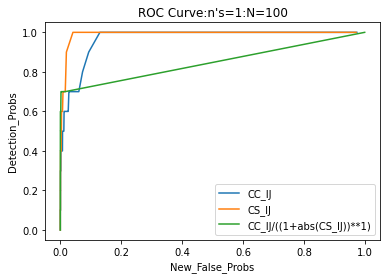

In [27]:
x.ROC_Curve(1, 100, new_stat_only=False)